# Movie Recommendation System

## Importing Required Libraries 

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
ratings = pd.read_csv('/content/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])
movies = pd.read_csv('/content/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])
movies_df = movies
ratings_df = ratings

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of released movies

In [ ]:
geners = movies_df['genres'].apply(lambda generlist : generlist.split("|"))
geners

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

<BarContainer object of 20 artists>

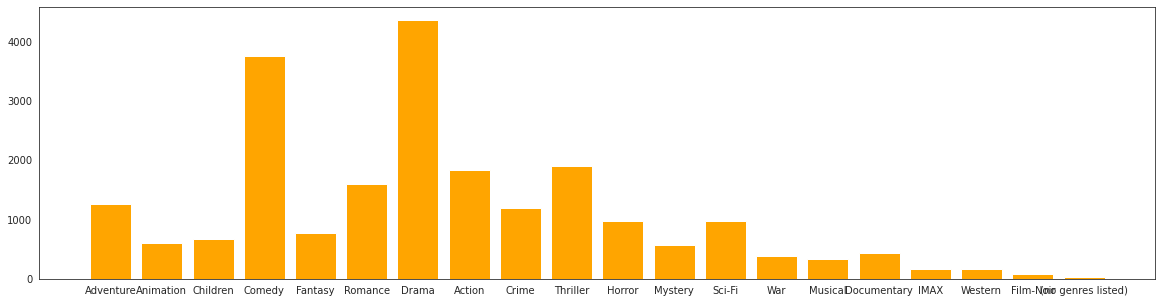

In [ ]:
plt.figure(figsize=(20,5))
geners_count = {}
for i in geners:
    for j in i:
        if(geners_count.get(j,False)):
            geners_count[j]=geners_count[j]+1
        else:
            geners_count[j] = 1       
plt.bar(geners_count.keys(),geners_count.values(),color='orange')

### Distribution of users rating to find outliers

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


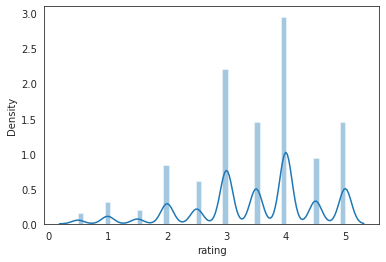

In [ ]:
sns.distplot(ratings_df["rating"]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


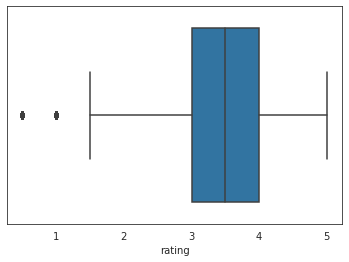

In [ ]:
sns.boxplot(ratings_df['rating'])

In [ ]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(ratings_df.shape)+"\n Movies DataFrame"+ str(movies_df.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


In [ ]:
merged_ratings = pd.merge(movies_df, ratings_df, on='movieId', how='inner')

In [ ]:
merged_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [ ]:
merged_ratings = merged_ratings.drop('timestamp', axis=1)

In [ ]:
merged_ratings.shape

(100836, 5)

#Content based filtering



*   Define a TF-IDF Vectorizer Object.
*   Replacing NaN with an empty string.



In [ ]:
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
movies_df['genres'] = movies_df['genres'].replace(to_replace="(no genres listed)", value="")

* Construct the required TF-IDF matrix by fitting and transforming the data
* Computing the cosine similarity matrix

In [ ]:
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies_df['genres'])
print(tfidf_movies_genres.get_feature_names())
print(tfidf_movies_genres_matrix.shape)
print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
print(cosine_sim_movies)

['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'imax', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']
(9742, 19)
float64
[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


Calculating the top 2 movies to recommend based on given movie titles genres.

In [ ]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    idx_movie = movies_df.loc[movies_df['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)
    sim_scores_movies = sim_scores_movies[1:5]
    movie_indices = [i[0] for i in sim_scores_movies]
    return movies_df['title'].iloc[movie_indices]


In [ ]:
get_recommendations_based_on_genres("Toy Story (1995)")

1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
Name: title, dtype: object

Calculating top movies to be recommended to user based on movie user has watched.

In [ ]:
def get_recommendation_content_model(userId):
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings_df[ratings_df["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((movies_df["title"][row["movieId"]==movies_df["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)   
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)

In [ ]:
get_recommendation_content_model(101)

{'39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'AlienÂ³ (a.k.a. Alien 3) (1992)',
 'Allan Quatermain and the Lost City of Gold (1987)',
 'Amateur (1994)',
 'American President, The (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Armour of God II: Operation Condor (Operation Condor) (Fei ying gai wak) (1991)',
 'Around the World in 80 Days (1956)',
 'Back to the Future (1985)',
 'Back to the Future Part II (1989)',
 'Batman Returns (1992)',
 'Beautiful Girls (1996)',
 'Beauty and the Beast (1991)',
 'Ben-Hur (1959)',
 'Beverly Hills Ninja (1997)',
 'Big Bully (1996)',
 'Bio-Dome (1996)',
 'Blink (1994)',
 'Blown Away (1994)',
 'Broken Arrow (1996)',
 'Carpool (1996)',
 'Clear and Present Danger (1994)',
 'Cliffhanger (1993)',
 'Clueless (1995)',
 'Crocodile Dundee II (1988)',
 'Cry, the Beloved Country (1995)',
 'Dangerous Minds (1995)',
 'Dead Man Walking (1995)',
 'Demolition Man (1993)',
 'Discreet Charm of the Bourgeoisie, The

# Model evaluation with KNN
Here the model is evaluated based on if there is exact match of genres with the genres of movie which is already watch by user 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = movies_df.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [ ]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    for key, colums in movies_df.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.9325087251077807
Fault:0.06749127489221926
